In [5]:
# Load the required libraries
import os
os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_TF"] = "1"

import pandas as pd
import numpy as np
import json
import transformers

transformers.utils.import_utils._is_torch_available = lambda: True
transformers.utils.import_utils._is_tf_available = lambda: False

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [6]:
# Load customer search history and product catalog
with open('../data/search_history.json', encoding='utf-8') as f:
    search_data = json.load(f)

with open('../data/fashion_catalog.json', encoding='utf-8') as f:
    catalog_data = json.load(f)

catalog_df = pd.DataFrame(catalog_data)

# Combine product info into a searchable text field
catalog_df['text'] = catalog_df[['CATEGORY', 'SHORT_DESCRIPTION', 'LONG_DESCRIPTION']]\
    .fillna('').agg(' '.join, axis=1)

In [7]:
# Load sentence embedding model and compute embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extract search queries only (filtering titles)
search_queries = [entry['title'] for entry in search_data if entry['header'].lower() == 'search']

# Subset of 10 is used for quick testing
query_embeddings = model.encode(search_queries[:10], show_progress_bar=True)
catalog_embeddings = model.encode(catalog_df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [8]:
# Recommendation function
def recommend(query_idx, top_k=5):
    q_vec = query_embeddings[query_idx].reshape(1, -1)
    sims = cosine_similarity(q_vec, catalog_embeddings).flatten()
    top_idx = sims.argsort()[::-1][:top_k]
    results = catalog_df.iloc[top_idx][['CATEGORY', 'SHORT_DESCRIPTION', 'LONG_DESCRIPTION']].copy()
    results['similarity_score'] = sims[top_idx]
    return results


Top matches for: Visited https://www.businessinsider.com/shivon-zilis-reported-mother-elon-musk-twins-2022-7?amp
      CATEGORY                                  SHORT_DESCRIPTION  \
60065     tops                                         Round Neck   
15273    jeans                                             Skinny   
94166  watches  Fm1G085L0041 Mother Of Pearl Dial Calfskin Lea...   
53403     tops                               Etza Blurred T-Shirt   
6757     pants                                              Chino   

       similarity_score  
60065          0.338615  
15273          0.328274  
94166          0.283528  
53403          0.282067  
6757           0.280520  


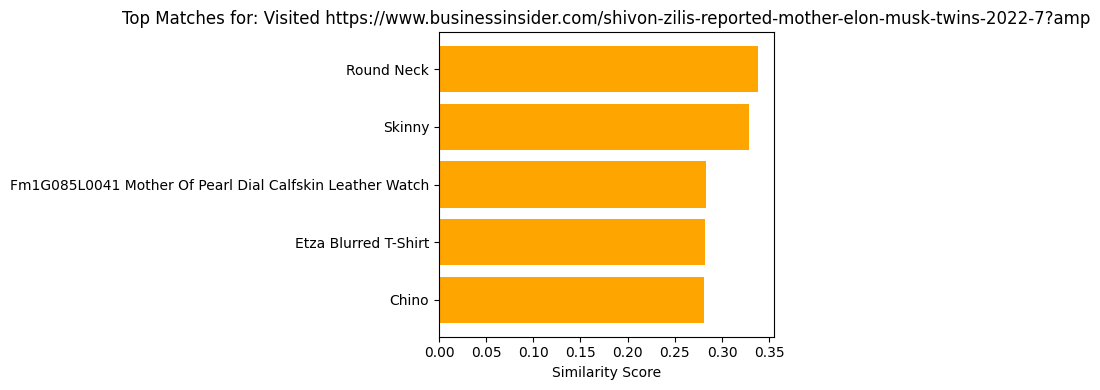


Top matches for: Visited Elon Musk and Shivon Zilis privately welcome third baby – NBC10 ...
      CATEGORY              SHORT_DESCRIPTION  similarity_score
76737    coats                        Zorinah          0.343910
13567    boots                         Julian          0.335616
21329   shorts  Ricky Sn Shrt Cln Hem Zig Zag          0.329393
42593   shirts              Zigzag Shirt Sn34          0.315775
88105   shirts              Ekyno 10260730 01          0.306825


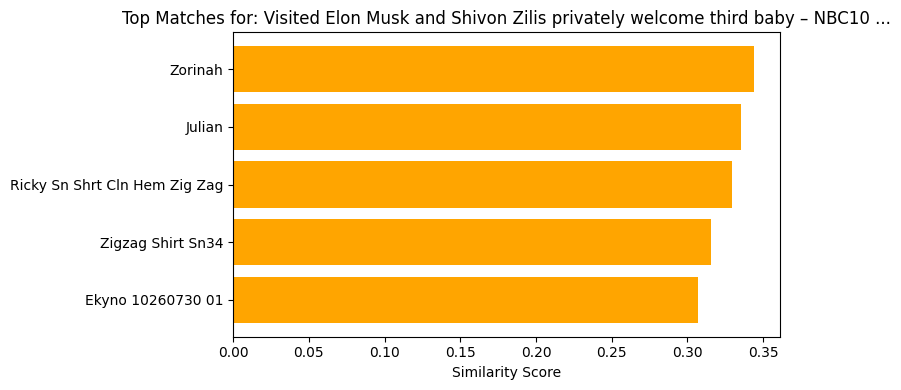


Top matches for: Searched for elon musk shivon zilis
       CATEGORY              SHORT_DESCRIPTION  similarity_score
88105    shirts              Ekyno 10260730 01          0.391898
42593    shirts              Zigzag Shirt Sn34          0.378594
96239  knitwear                    Sweatshirts          0.371459
47700   dresses                    Mutka Dress          0.357090
70271    shirts  L-jon-kent-c1-233 10109654 01          0.357006


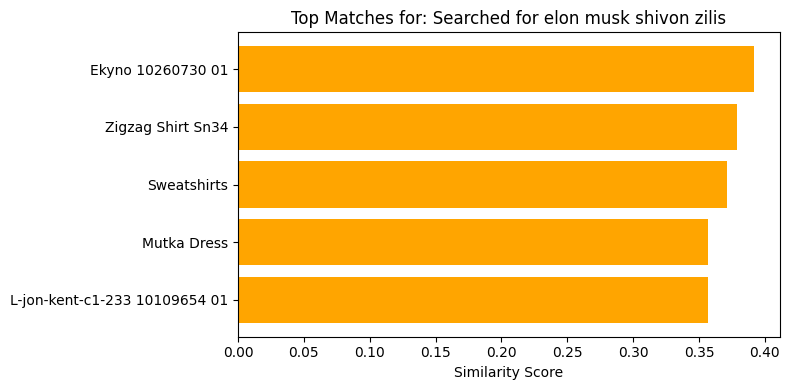


Top matches for: 1 notification
        CATEGORY                            SHORT_DESCRIPTION  \
79973      flats                             Golden Glow Jn42   
13824  necklaces  Silence + Noise Split Fish Pendant Necklace   
12026  bracelets       Silence + Noise Antique Charm Bracelet   
78884     sweats                            Salbo 10256713 01   
93781    jackets                        C_palassy 10239121 01   

       similarity_score  
79973          0.280397  
13824          0.274770  
12026          0.262267  
78884          0.259516  
93781          0.258673  


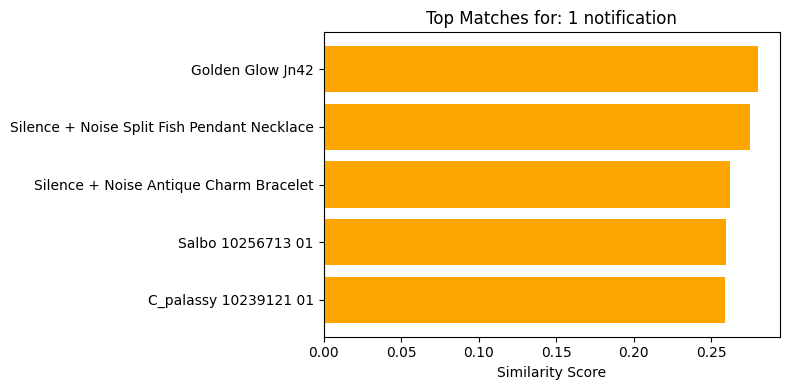


Top matches for: Searched for bank station fire alert
      CATEGORY        SHORT_DESCRIPTION  similarity_score
56839  wallets         Fg Florence Sn43          0.373832
3326   wallets        Mount Street Ld99          0.291483
51238    flats  Birkenstock Birkenstock          0.269492
65778     tops        Fegan 10213028 01          0.267426
92100  wallets                   Wallet          0.261609


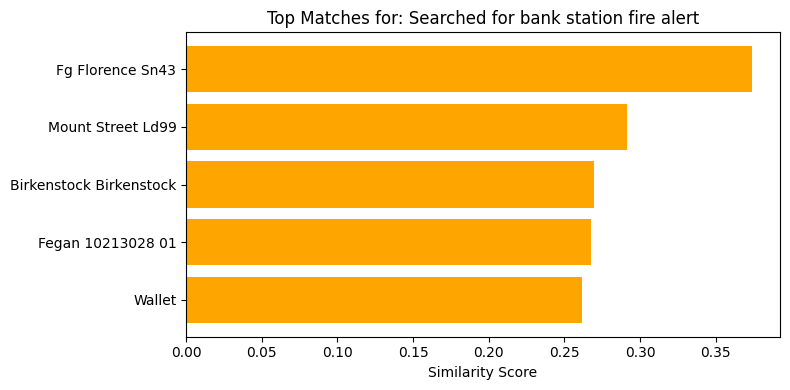

In [9]:
# Generate top recommendations and plot
for i, query in enumerate(search_queries[:5]):
    print(f"\nTop matches for: {query}")
    recs = recommend(i)
    print(recs[['CATEGORY', 'SHORT_DESCRIPTION', 'similarity_score']])

    # Plot similarity scores
    plt.figure(figsize=(8, 4))
    plt.barh(recs['SHORT_DESCRIPTION'], recs['similarity_score'], color='orange')
    plt.xlabel("Similarity Score")
    plt.title(f"Top Matches for: {query}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [10]:
# Save the recommendations into a csv file 
final_results = []
for i, query in enumerate(search_queries[:5]):
    recs = recommend(i)
    recs['query'] = query
    final_results.append(recs)

pd.concat(final_results).to_csv("recommendations_output.csv", index=False)

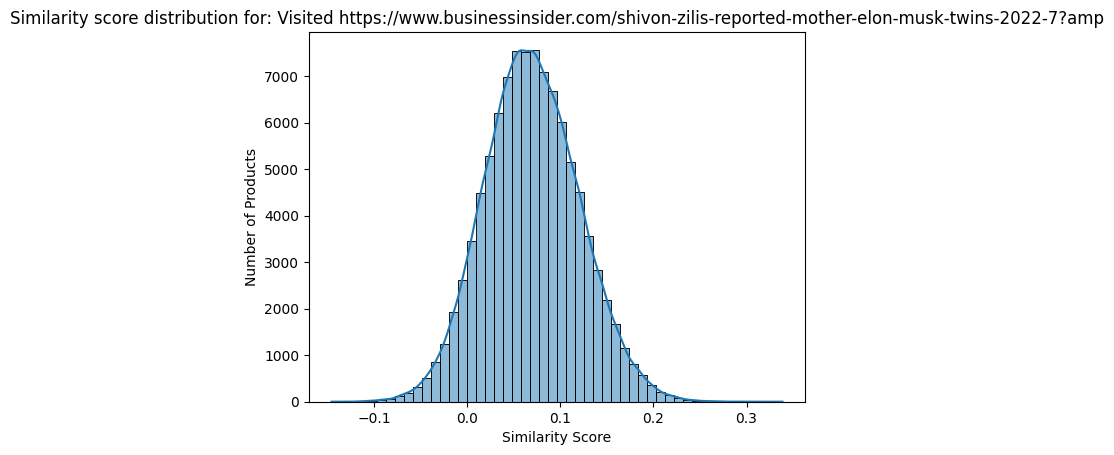

In [11]:
# Histogram of similarity scores for one query
import seaborn as sns

sims = cosine_similarity([query_embeddings[0]], catalog_embeddings).flatten()
sns.histplot(sims, bins=50, kde=True)
plt.title(f"Similarity score distribution for: {search_queries[0]}")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Products")
plt.show()  